In [1]:
import tensorflow as tf
import gym
from matplotlib import pyplot as plt

In [2]:
env = gym.make('MsPacman-v0')
env

<TimeLimit<AtariEnv<MsPacman-v0>>>

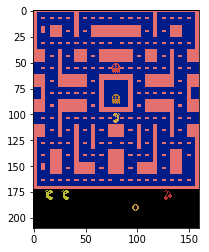

In [3]:
s = env.reset()
a = env.action_space.sample()
s_next, r, done, info = env.step(a)
env.close()

plt.imshow(s)

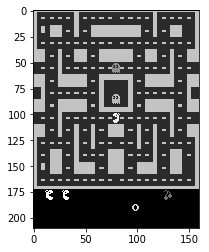

In [4]:
def grayscale(rgb_image):
    assert rgb_image.ndim == 3, "bad shape"
    assert rgb_image.shape[2] == 3, "bad shape"
    return rgb_image.dot([0.2125, 0.7154, 0.0721])


plt.imshow(grayscale(s), cmap='gray')

In [6]:
from keras_gym.utils import feature_vector

feature_vector(s, env.observation_space)

AssertionError: x must be 1d array, got shape: (210, 160, 3)

In [25]:
env.action_space

Discrete(9)